In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import investpy
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Download stock data

In [2]:
all_stocks = investpy.get_stocks_list(country='United States')
#all_stocks = investpy.etfs.get_etfs_list('united states')
print('There are {} etfs'.format(str(len(all_stocks))))
stocks_selected = all_stocks[:300]
print('out of which '+  str(len(stocks_selected)) + ' are chosen')

There are 4582 etfs
out of which 300 are chosen


In [3]:
#stocks_selected = ' '.join(stocks_selected)
data = yf.download(stocks_selected, start = "2010-01-02", end = "2020-09-05")

[*********************100%***********************]  300 of 300 completed

7 Failed downloads:
- BBT: No data found, symbol may be delisted
- PJC: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- STVVY: No data found, symbol may be delisted
- BFB: No data found for this date range, symbol may be delisted
- EP_PC: No data found for this date range, symbol may be delisted
- EUHMF: No data found, symbol may be delisted


In the paper, authors drop all assets that contain at least 1 non-traded day (nan). But if we do this here, no stocks would be left at all, so we interpolate missing values

In [4]:
close = data[['Adj Close']].interpolate(method = 'linear', axis = 1)# thresh = data.shape[0] * 0.95) #drop stock if 5% of days are absent
close.index = pd.to_datetime(close.index)
close.index = close.index.to_period(freq='d')
print(str(close.shape[1]) + ' etfs left')

300 etfs left


In [5]:
close.head(3)

Adj Close                                                  \
                   AA      AAPL  AAXN       ABC        ACN       ADBE   
Date                                                                    
2010-01-04  37.018944  6.604801  4.65  22.60673  33.595993  37.090000   
2010-01-05  35.862801  6.616219  4.70  22.44544  33.803631  37.700001   
2010-01-06  37.730419  6.510980  5.84  22.23321  34.162979  37.619999   

                                                       ...             \
                  ADI        ADM       ADSK       AGN  ...       WYNN   
Date                                                   ...              
2010-01-04  24.001997  23.668222  25.670000  37.54055  ...  41.963718   
2010-01-05  23.964100  23.796082  25.280001  37.16785  ...  44.515926   
2010-01-06  23.918631  23.735907  25.340000  37.28899  ...  43.932011   

                                                                               \
                  XEL       XLNX        XOM       XRAY        XRX       YGEHY   
Date                                                                            
2010-01-04  14.223065  19.886999  47.467609  33.034389  16.937948  164.300003   
2010-01-05  14.054389  19.636250  47.652931  32.641670  16.957575  185.000000   
2010-01-06  14.081378  19.503048  48.064804  32.856728  16.800566  179.699997   

                                          
              YRCW        ZBH       ZION  
Date                                      
2010-01-04  5400.0  55.568928  11.827960  
2010-01-05  5100.0  57.328018  12.244997  
2010-01-06  6075.0  57.309509  13.309779  

[3 rows x 300 columns]

In [6]:
returns = close.pct_change(fill_method='ffill').iloc[1:, :]
returns.head(3)

Adj Close                                                    \
                  AA      AAPL      AAXN       ABC       ACN      ADBE   
Date                                                                     
2010-01-05 -0.031231  0.001729  0.010753 -0.007135  0.006180  0.016446   
2010-01-06  0.052077 -0.015906  0.242553 -0.009455  0.010630 -0.002122   
2010-01-07 -0.021214 -0.001848 -0.030822 -0.016037 -0.000935 -0.019405   

                                                    ...                      \
                 ADI       ADM      ADSK       AGN  ...      WYNN       XEL   
Date                                                ...                       
2010-01-05 -0.001579  0.005402 -0.015193 -0.009928  ...  0.060819 -0.011859   
2010-01-06 -0.001897 -0.002529  0.002373  0.003259  ... -0.013117  0.001920   
2010-01-07 -0.007921 -0.010456  0.005525 -0.007996  ...  0.021356 -0.004312   

                                                                        \
                XLNX       XOM      XRAY       XRX     YGEHY      YRCW   
Date                                                                     
2010-01-05 -0.012609  0.003904 -0.011888  0.001159  0.125989 -0.055556   
2010-01-06 -0.006783  0.008643  0.006588 -0.009259 -0.028649  0.191176   
2010-01-07 -0.010044 -0.003142  0.013091  0.004673  0.003339  0.049383   

                                
                 ZBH      ZION  
Date                            
2010-01-05  0.031656  0.035259  
2010-01-06 -0.000323  0.086957  
2010-01-07  0.022940  0.112000  

[3 rows x 300 columns]

### Filter with AR(1)-TGARCH(1,1)

In [188]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model 
from arch.univariate import ARX, GARCH, StudentsT

In [189]:
all_ret = np.full((returns.shape[0]-1, returns.shape[1]), 0, dtype = 'float64')

col_names = returns.columns
for col in range(returns.shape[1]):
    #mod = HARX(close.iloc[:599], lags = [1, 2], rescale = False)
    #mod.volatility = GARCH(p=1, o=1, q=1)
    #mod.distribution = StudentsT()
    mod = arch_model(100 * returns.iloc[:, col],
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='skewstudent')#    StudentsT') 
    mod_fit = mod.fit(disp='off')
    all_ret[:, col] = mod_fit.resid[1:] 
all_ret = pd.DataFrame(all_ret, index = returns.index[1:], columns = returns.columns.droplevel(0), dtype = 'float64')

C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.068e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.497e+04. Parameter
estimation work better

In [190]:
all_res = np.full((599, close.shape[1]), 0,  dtype = 'float64')

for col in range(close.shape[1]):
   # mod = ARX(100 * returns.iloc[:, col], lags = [1, 2,])
   # mod.volatility = GARCH(p=1, o=1, q=1)
   # mod.distribution = StudentsT()
    mod = arch_model(10*close.iloc[:600, col],
                    mean='ARX', lags = 1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='skewstudent')#    StudentsT') 
    mod_fit = mod.fit(disp='off')
    all_res[:, col] = mod_fit.resid[1:] / 10
all_res = pd.DataFrame(all_res, index = close.index[1:600], columns = returns.columns.droplevel(0), dtype = 'float64')

C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\Dell\anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.186e+04. Parameter
estimation work better when this value is between 1 and 1000. The 

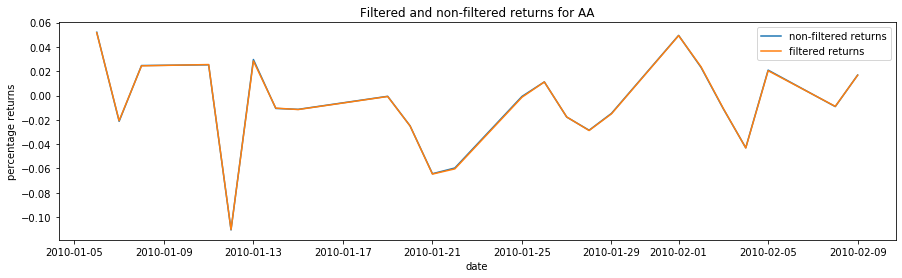

In [191]:
plt.figure(figsize = (15,4))
plt.plot(returns.index.to_timestamp()[1:25], returns.iloc[1:25, 0] , label = 'non-filtered returns');
plt.plot(returns.index.to_timestamp()[1:25], all_ret.iloc[:24, 0] / 100, label = 'filtered returns');
plt.title('Filtered and non-filtered returns for {}'.format(all_ret.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('percentage returns');

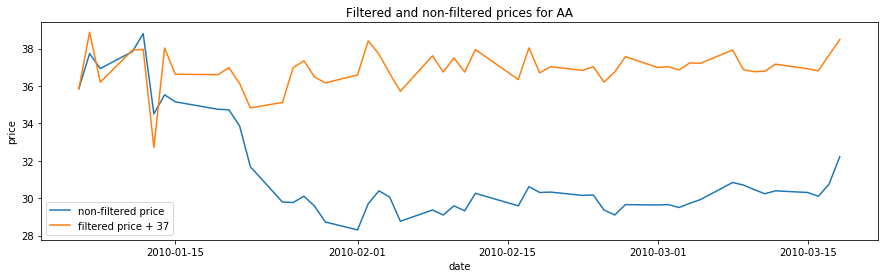

In [192]:
plt.figure(figsize = (15,4))
plt.plot(returns.index.to_timestamp()[1:51], close.iloc[1:51, 0], label = 'non-filtered price');
plt.plot(returns.index.to_timestamp()[1:51], all_res.iloc[:50, 0] + 37, label = 'filtered price + 37');
plt.title('Filtered and non-filtered prices for {}'.format(all_res.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('price');

### PCA dimensionality reduction and OPTICS clustering
   The authors use 15 principal components in PCA but we use a larger number due to the fact that out time series is longer (authors had 8 years of training data) and it could be we cannot describe it well in 15 components. Then, these components serve as input to OPTICS - density based clustering method. To choose among models, we use silhouette score. It is in range between -1 and 1, the higher it is the better.

In [193]:
def find_max(silhouette):
    all_vals = []
    for val in silhouette.values():
        all_vals.extend(val)
    return all_vals

def best_params(silhouette):
    all_vals = find_max(silhouette)
    max_val = max(all_vals)
    for key, val in silhouette.items():
        if max_val in val:
            return key, val.index(max_val) + 2, max_val

In [194]:
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

silhouette = dict()
for comp in range(2, 16):
    partial_silh = list()
    pca = PCA(n_components = comp, svd_solver = 'auto')
    pca_fit = pca.fit_transform(all_ret.transpose())
    for min_sampl in range(2, 7):
        try:
            clusters = OPTICS(min_samples = min_sampl).fit(pca_fit) #metric = 'euclidean' min_cluster_size = 5
            partial_silh.append(silhouette_score(pca_fit, clusters.labels_))
        except: pass
    silhouette[comp] = partial_silh
    
best_comp, best_min_smpl, best_score = best_params(silhouette)
print('best silhouette_score is ' + str(best_score) + ' at ' + str(best_min_smpl) + ' min_samples and ' +
      str(best_comp) + ' components')

best silhouette_score is 0.18795830269433875 at 2 min_samples and 2 components


In [195]:
pca = PCA(n_components = best_comp, svd_solver = 'auto')
pca_fit = pca.fit_transform(all_ret.transpose())
clusters = OPTICS(min_samples = best_min_smpl).fit(pca_fit)

Number of clusters is 89


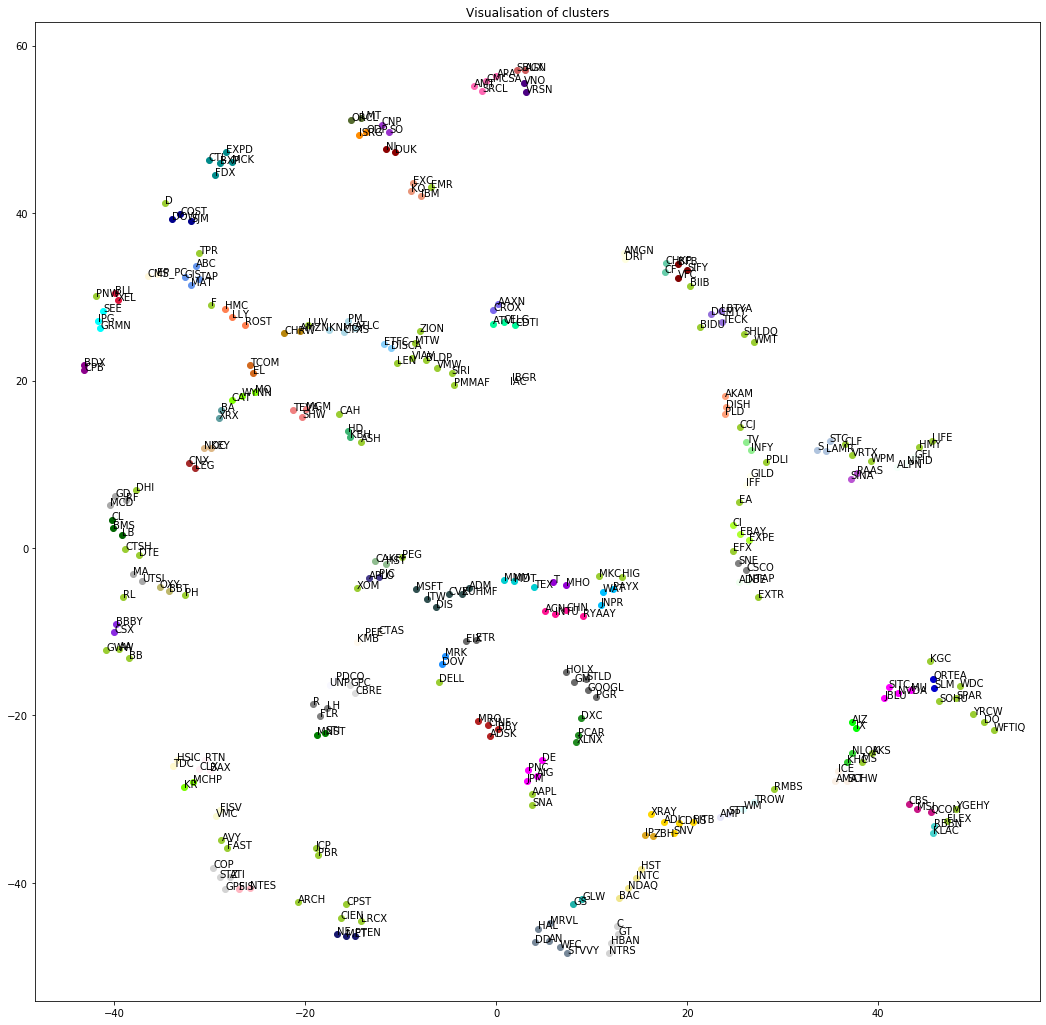

In [248]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

tsne = TSNE(n_components = 2, perplexity = 6).fit_transform(pca_fit)

print('Number of clusters is ' + str(clusters.labels_.max()-clusters.labels_.min()))
colors = list(mcolors.CSS4_COLORS.keys())[10:]
plt.figure(figsize=(18,18))
for klass in range(clusters.labels_.min(), clusters.labels_.max()):
    plt.scatter(tsne[clusters.labels_ == klass][:, 0], tsne[clusters.labels_ == klass][:, 1],
               c = colors[klass], label = 'class {}'.format(str(klass)))
for i, txt in enumerate(all_ret.columns):
    plt.annotate(txt, (tsne[i, 0], tsne[i, 1]))
#plt.legend()
plt.title('Visualisation of clusters');

In [197]:
#do not include class -1 since these are outliers/points without claster
classes = dict()
for cl in range(0, clusters.labels_.max()): 
    klass = all_res.transpose()[clusters.labels_ == cl]
    classes[cl] = klass

### Select pairs
Next, we select pairs based on the following criteria:
- cointegration
- Hurst exponent < 0.5
- half-life of mean reversion
- average number of crossings of spread mean per year

In [198]:
from statsmodels.tsa.stattools import coint

In [199]:
pairs = list()
for cl in classes.keys():
    tested_pairs = list()
    for smpl in range(classes[cl].shape[0]):
        for smpl2 in range(classes[cl].shape[0]):
            if smpl != smpl2 and (smpl2, smpl) not in tested_pairs: #no cointegration with itself, check pair has not been tested
                tested_pairs.append((smpl2, smpl))
                cointegrated = coint(classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2, :], return_results = True)
                if cointegrated[1] < 0.05: #pvalue
                    pairs.append([classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2,:]])    
print('There are {} pairs at this stage'.format(len(pairs)))

There are 424 pairs at this stage


In [200]:
#check spread mean-reversion
from hurst import compute_Hc

for pair in pairs:
    spread = pair[0] - pair[1]
    H, c, data = compute_Hc(spread)
    if H >= 0.5: #Brownian motion or persistent
        for ts in pair:
            pair.remove(ts)
        pairs.remove(pair)
print('There are {} pairs at this stage'.format(len(pairs)))

There are 417 pairs at this stage


In [201]:
#check mean-reversion half life
# https://letianzj.github.io/mean-reversion.html
from scipy.ndimage.interpolation import shift
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()
for pair in pairs:
    defective = 0
    for ts in pair:
        ts_delta = ts - ts.shift()
        lin_reg.fit(np.array(ts.shift()[1:]).reshape(-1,1), np.array(ts_delta[1:]).reshape(-1,1)) 
        half_life = -np.log(2) / lin_reg.coef_.item()
        if half_life < 1 or half_life > 365:
            defective += 1
            pair.remove(ts)
    if defective > 0:
        pairs.remove(pair)
print('There are {} pairs at this stage'.format(len(pairs)))

There are 208 pairs at this stage


In [202]:
#check that on average there are at least 12 crossings of spread mean per year
years_num  = len(returns.index.to_timestamp().year.unique())
for pair in pairs:
    spread = pair[0] - pair[1]
    crosses = 0
    for i in range(len(spread) - 1):
        if (spread[i] > spread.mean() and spread[i + 1] < spread.mean()) or (spread[i] < spread.mean() and spread[i + 1] > spread.mean()):
            crosses += 1
    if crosses < 12 * years_num:
        for ts in pair:
            pair.remove(ts)
        pairs.remove(pair)
print('There are {} pairs at this stage'.format(len(pairs)))

There are 203 pairs at this stage


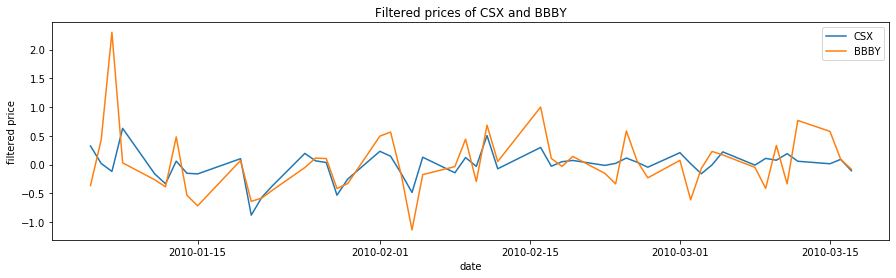

In [204]:
plt.figure(figsize = (15, 4))
plt.plot(pairs[0][0].index.to_timestamp()[:50], pairs[0][0][:50], label = pairs[0][0].name)
plt.plot(pairs[0][1].index.to_timestamp()[0:50], pairs[0][1][:50], label = pairs[0][1].name)
plt.legend()
plt.xlabel('date')
plt.ylabel('filtered price')
plt.title('Filtered prices of {} and {}'.format(pairs[0][0].name, pairs[0][1].name));

### Spread prediction

In [205]:
spread = pairs[0][0] - pairs[0][1]
spread_chg = (spread.shift(-1) - spread)[:-1]
#spread[spread == 0] = 0.00000001 #to avoid division by zero
spread_chg = spread_chg / spread[:-1] 

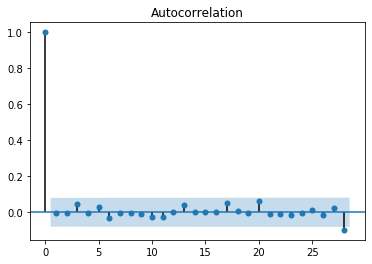

In [206]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(spread_chg); #it is rather small, so try lags in range of 1

In [265]:
from statsmodels.tsa.arima.model import ARIMA
#remove spread from all_res cause it is not prie
#predictions = np.full((2, close.shape[1]), 0,  dtype = 'float64')
arma = ARIMA(np.array(spread_chg), order = (1,0,1)).fit()
pred = arma.forecast(steps=2, exog=None, alpha=0.01)
#check index
spread_chg.append(pd.Series(pred, name = all_ret.columns[0], index = all_res.index[-2:] + pd.Timedelta(days=1)))
#predictions[:,0] = pred
#date = all_res.index.to_timestamp()[-2:]
#predictions = pd.DataFrame(predictions, dtype = 'float64', index = date + pd.Timedelta(days=2), columns = all_res.columns)
#all_res = all_res.append(predictions)

Date
2010-01-05            -1.603613
2010-01-06             4.831100
2010-01-07            -1.247775
2010-01-08            -0.830071
2010-01-11            -0.480728
                         ...   
2012-05-15             0.850167
2012-05-16            -4.474245
2012-05-17            -0.963889
2012-05-20 00:00:00    0.239712
2012-05-21 00:00:00    0.235695
Length: 600, dtype: float64

In [235]:
quantiles = np.quantile(all_res.iloc[:, 0], [0.1,0.9, 0.2, 0.8], interpolation = 'linear')

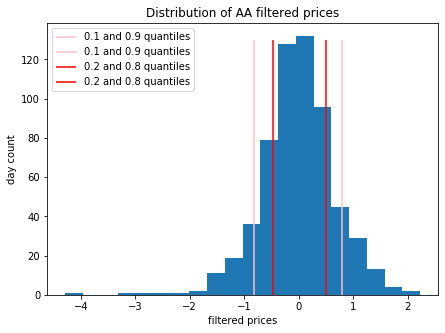

In [242]:
plt.figure(figsize=(7,5))
plt.hist(all_res.iloc[:,0], bins = 20)
plt.title('Distribution of {} filtered prices'.format(all_res.columns[0]))
plt.xlabel('filtered prices')
plt.ylabel('day count')
for quant in quantiles[:2]:
    plt.vlines(quant, 0, 130, colors = 'pink', label = '0.1 and 0.9 quantiles')
for quant in quantiles[2:]:
    plt.vlines(quant, 0, 130, colors = 'red', label = '0.2 and 0.8 quantiles')
plt.legend();

In [268]:
a_sh = quantiles[0]
a_lo = quantiles[1]

In [270]:
comission = 0.001
account = 0
for day, delta in enumerate(spread_chg):
    if delta >= a_sh:
        account -= pairs[0][0][day] * (1 + comission)
        account += pairs[0][1][day] * (1 - comission)
    elif delta <= a_lo:
        account += pairs[0][0][day] * (1 - comission)
        account -= pairs[0][1][day] * (1 + comission)
account

-5.4003203047277015